# Speed Dating Data
https://www.kaggle.com/annavictoria/speed-dating-experiment

# 3 Feature Engineering/Pre-processing & Modeling (ver. keep chosen categorical columns), both female and male decisions


## 3.1  Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
import pickle
import sys 

from pandas_profiling import ProfileReport
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.decomposition import PCA
from sklearn import metrics

import statsmodels.api as sm

import shap
shap.initjs() #%%%%% what is this for?

import collections

from sb_utils import save_file

In [2]:
# not sure if I need this
import datetime
import unicodedata
import re
from sklearn.preprocessing import scale

## 3.2 Objectives

In the data wrangling notebook, we have identified our target dependent variable as desicion of parner of the specific subject, dec_o (might also consider match, desicion from both the subject and the partner) and cleaned the data accordingly. In this notebook, we will conduct further EDA, hoping to answer following questions.

1. What are the desirable attributes?
2. What are the desirable races?
3. What are the desirable majors?
4. The difference of desirable attributes in a male partner vs female partner.
5. The difference of desirable attributes among races.
6. The difference of desirable major of male partner vs female partner
7. The difference of desirable majors among races.   

**Learning Objectives**:
Preprocessing:
1. Understand the importance of creating a model training development data set.
2. Correctly identify when to create dummy features or one-hot encoded features.
3. Understand the importance of magnitude standardization.
4. Apply the train and test split to the development dataset effectively

Modeling:
1. Fit your models with a training dataset 
    - Use cross-validation for hyperparameter tuning
2. Review model outcomes — Iterate over additional models as needed
    - Caclulate accuracy, recall, precision, and F1.
3. Identify the final model that you think is the best model for this project
    - Most power model interms of model evaluation metrics, computational complexity, scalability, and maintenance costs.

Here is possible workflow: TBD
1. Pre-processing:
    - Removed columns with categorical meaning before fillna with mean
    - Got dummy variables for all the columns with categorical meaning and with missing data
        - Converted the type int/float to object beforehand.
        - Make sure to use pd.get_dummies(df, drop_first=False), without dropping rows with missing values. Leave the first column so that missing value information is not lost.  Missing value can be considered as a category label as its own.
        - Removed the original categorical columns with missing data
    - Split into training/test set > fill NaN with mean, scale within training set and test set separately
        - Extract columns with numeric meaning to scale
        - Removed dummy variables columns and binary columns before scaling the numeric columns
        - Combined the dummy variable columns, binary columns and scaled numeric columns per train set and test set.
    - perform PCA on scaled numeric columns to reduce dimension
        - Keep enough pca components to explain ~90% var. 
        - Combined the dummy variable columns, binary columns and pca columns from scaled numeric columns
2. Modeling:
    - logistic regression model via sklearn and statsmodel
        - Use GridSearchCV (cv=5) for feature engineering
        - Use stepwise selection, elastic-net (or L1/L2 regularizers) if possible
    - Random Forest model via sklearn
    - Model evaluation
        - Fit null model
        - Evaluate the fit on the training data (make sure everything is working, is the metric acceptable?)
        - Perform threshold anlaysis
            - pick the threshold using the training dataset
            - evaluate on the test data 
            - make sure to compare train dataset and test dataset results (should look comparable)
        - Evaluate the distributions of predicted values (probabilities) on both train & test dataset
        - Compare all models using confusion matrix and classification report    
3. Feature importance analysis
    - Use SHAP for sklearn model
    - in order to answer feature importance for Male and Female, ran the model with male data and female data separately (not done).
    - in ordr to answer feature importance for different races, can run the model with each race seprately (not done)

## 3.3 Load The Data

In [3]:
# df = pd.read_csv('../data/ski_data_cleaned.csv')
spd = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_cleaned.csv') #spd1_2 in data wrangling notebook
spd_fp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_FemaleRatingMale_cleaned.csv') # spd1_2fp in data wrangling notebook 
spd_mp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_MaleRatingFemale_cleaned.csv') # spd1_2mp in data wrangling notebook

In [4]:
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [5]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   race      6208 non-null   float64
 4   field     6208 non-null   object 
 5   career    6182 non-null   object 
 6   from      6192 non-null   object 
 7   goal      6192 non-null   float64
 8   int_corr  6118 non-null   float64
 9   samerace  6266 non-null   int64  
 10  imprace   6192 non-null   float64
 11  imprelig  6192 non-null   float64
 12  age_o     6189 non-null   float64
 13  race_o    6198 non-null   float64
 14  dec_o     6266 non-null   int64  
 15  attr_o    6127 non-null   float64
 16  sinc_o    6064 non-null   float64
 17  intel_o   6054 non-null   float64
 18  fun_o     5999 non-null   float64
 19  amb_o     5709 non-null   float64
 20  shar_o    5399 non-null   floa

In [6]:
# check for NaN
spd.isna().sum() 
# need to remove cotegorical feature with type int or float before fill NaN with mean
# remove: race, goal, race_o, met_o > leave put to be dealt with dummy variables

gender        0
match         0
age          68
race         58
field        58
career       84
from         74
goal         74
int_corr    148
samerace      0
imprace      74
imprelig     74
age_o        77
race_o       68
dec_o         0
attr_o      139
sinc_o      202
intel_o     212
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
met_o       269
dtype: int64

In [7]:
# check for column value range
spd.describe()

,gender,match,age,race,goal,int_corr,samerace,imprace,imprelig,age_o,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
count,6266.000000,6266.000000,6198.000000,6208.000000,6192.000000,6118.000000,6266.000000,6192.000000,6192.000000,6189.000000,...,6266.000000,6127.000000,6064.000000,6054.000000,5999.000000,5709.000000,5399.000000,6104.000000,6054.000000,5997.000000
mean,0.500798,0.170763,26.257180,2.691205,2.152616,0.192596,0.405043,3.804748,3.734981,26.265148,...,0.427705,6.233132,7.223615,7.403204,6.418736,6.826152,5.554269,6.166317,5.233812,1.956145
std,0.500039,0.376332,3.525651,1.219243,1.430158,0.303994,0.490940,2.882531,2.814576,3.521609,...,0.494785,1.934149,1.717217,1.528342,1.952552,1.770204,2.141403,1.850402,2.142853,0.263864
min,0.000000,0.000000,18.000000,1.000000,1.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,24.000000,2.000000,1.000000,-0.017500,0.000000,1.000000,1.000000,24.000000,...,0.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,4.000000,2.000000
50%,1.000000,0.000000,26.000000,2.000000,2.000000,0.210000,0.000000,3.000000,3.000000,26.000000,...,0.000000,6.000000,7.000000,8.000000,7.000000,7.000000,6.000000,6.000000,5.000000,2.000000
75%,1.000000,0.000000,28.000000,4.000000,2.000000,0.430000,1.000000,6.000000,6.000000,28.000000,...,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,2.000000
max,1.000000,1.000000,42.000000,6.000000,6.000000,0.900000,1.000000,10.000000,10.000000,42.000000,...,1.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000,8.000000


In [8]:
# met_o supposed to be binary (1 or 2) column but it was not. double check its unique value
spd.met_o.unique() # people might have mistakenly input how many times have met before?

array([ 2.,  1., nan,  3.,  5.,  6.,  7.,  8.])

In [9]:
# check the value of categorical columns we want to get dummy variables
spd.race.unique()

array([ 4.,  2.,  6.,  3.,  1., nan])

In [10]:
spd.race_o.unique()

array([ 2.,  4.,  3.,  6.,  1., nan])

In [11]:
spd.field.unique() # too much but want to keep it for now

array(['Law', 'law', 'Economics', 'Masters in Public Administration',
       'Masters of Social Work&Education', 'Finance', 'Business',
       'political science', 'money', 'Operations Research',
       'TC (Health Ed)', 'Psychology', 'social work', 'Social Work',
       'Speech Language Pathology', 'Speech Languahe Pathology',
       'Educational Psychology', 'Applied Maths/Econs', 'Mathematics',
       'Statistics', 'Organizational Psychology',
       'Mechanical Engineering', 'Finanace', 'Finance&Economics',
       'Undergrad - GS', 'Mathematical Finance', 'Medicine', 'MBA', 'LAW',
       nan, 'psychology', 'German Literature',
       'Business & International Affairs', 'MFA Creative Writing',
       'Engineering', 'Electrical Engineering', 'Classics',
       'Operations Research (SEAS)', 'chemistry', 'Journalism',
       'Elementary/Childhood Education (MA)', 'microbiology',
       'Masters of Social Work', 'Communications', 'Marketing',
       'Chemistry', 'International Education

In [12]:
spd['from'].unique() # spd.from.unique() didn't work, too much options > drop b/c less interested

array(['Chicago', 'Alabama', 'Connecticut', 'Texas', 'Bowdoin College',
       'MD', 'Southern California', 'London, England',
       'Palm Springs, California', '94115', 'Argentina', 'England',
       'Cincinnati, Ohio', 'Miami', 'Milan - Italy', 'Georgia, USA',
       'New York', 'california', 'Washington DC', 'New Jersey',
       'Ann Arbor, MI', 'Hong Kong', 'new york', 'Iowa', 'California',
       'Westchester, NY', nan, 'Washington, DC', 'Boston', 'new jersey',
       'Michigan', 'SIngapore', 'Brazil', 'Brandeis University',
       'Cincinnati, OH', 'Los Angeles', 'SF Bay Area, CA', 'China',
       'San Francisco(home)/Los Angeles(undergrad)', 'Spain', 'Israel',
       'Switzerland', 'Italy', 'Philadelphia', 'Houston', 'Brooklyn',
       'Florida', 'Tuscaloosa, Alabama', 'Albuquerque, NM',
       'Palo Alto, California', 'Boston, MA', 'Mexico', 'Torrance, CA',
       'St. Louis, MO', 'London, UK', 'Minnesota', 'Ohio',
       'India/Venezuela', 'Washington State', 'Panama', 'spain

In [13]:
spd.career.unique() # too much options... this is 'intended' career > drop will keep filed instead 
# if want to include this, can reduce the option by merging similar ones.

array(['lawyer', 'law', 'Economist', 'lawyer/policy work', 'Law',
       'Journalist', 'Congresswoman, and comedian',
       'To create early childhood intervention programs',
       'Academia, Research, Banking, Life', 'Corporate Lawyer', 'Lawyer',
       'Corporate attorney', 'research/financial industry',
       'academics or journalism', 'Financial Services', 'ceo', 'CEO',
       'Undecided', 'Informatics', 'psychologist',
       'health/nutrition oriented social worker', 'Social Worker',
       'Social work with children', 'Speech Language Pathologist', nan,
       'Social Work Administration', 'Professor', "Clidren's TV",
       'Banking', 'Capital Markets', 'Biostatistics',
       'Organizational Change Consultant', 'tech professional',
       'Engineer', 'Academic', 'academia', 'banker / academia', 'banker',
       'Music production', 'Entrepreneur',
       'Intellectual Property Attorney', 'Medicine', 'consulting',
       'LAWYER', 'social worker', 'comedienne', 'attorney',
  

In [14]:
spd.goal.unique() # goal for attending this speed dating, not many options so will keep

array([ 2.,  1.,  6.,  3.,  4., nan,  5.])

## 3.4 Pre-processing data

### 3.4.1 Get dummy variables of chosen categorical columns

In [15]:
# exctract categorical data
# refer to '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk'
# dfo = df.select_dtypes(include='object')
# spd1 = spd[['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o']]  
#%%%%% converting all this features to variables took forever to run the ML model
spd1 = spd[['race', 'field', 'goal', 'race_o', 'met_o']]  # dropped less interested features
# did not include 'gender' and 'match' columns b/c they are binary column w/o missing data
spd1.head()

,race,field,goal,race_o,met_o
0,4.0,Law,2.0,2.0,2.0
1,4.0,Law,2.0,2.0,2.0
2,4.0,Law,2.0,4.0,1.0
3,4.0,Law,2.0,2.0,2.0
4,4.0,Law,2.0,3.0,2.0


In [16]:
# check column type
spd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    6208 non-null   float64
 1   field   6208 non-null   object 
 2   goal    6192 non-null   float64
 3   race_o  6198 non-null   float64
 4   met_o   5997 non-null   float64
dtypes: float64(4), object(1)
memory usage: 244.9+ KB


In [17]:
# convert to object type 
spd1_o = spd1.astype('object') #%%%%% get_dummies did not work on int/float type
spd1_o.head()

,race,field,goal,race_o,met_o
0,4,Law,2,2,2
1,4,Law,2,2,2
2,4,Law,2,4,1
3,4,Law,2,2,2
4,4,Law,2,3,2


In [18]:
# check column type
spd1_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    6208 non-null   object
 1   field   6208 non-null   object
 2   goal    6192 non-null   object
 3   race_o  6198 non-null   object
 4   met_o   5997 non-null   object
dtypes: object(5)
memory usage: 244.9+ KB


In [19]:
# get dummy variable from the exctracted categorical data
# refer to 14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
spd1_odm = pd.get_dummies(spd1_o) # since spd1_o categorial type features still have many missing data, kept drop_first=False
spd1_odm.head() # pd.get_dummies() automatically removed the orignal categorical variables

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [20]:
# check for NaN
spd1_odm.isna().sum()

race_1.0     0
race_2.0     0
race_3.0     0
race_4.0     0
race_6.0     0
            ..
met_o_3.0    0
met_o_5.0    0
met_o_6.0    0
met_o_7.0    0
met_o_8.0    0
Length: 222, dtype: int64

In [21]:
spd1_odm.shape

(6266, 222)

In [22]:
# extract the numeric data
spd2 = spd.drop(columns=['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o'])
spd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   int_corr  6118 non-null   float64
 4   samerace  6266 non-null   int64  
 5   imprace   6192 non-null   float64
 6   imprelig  6192 non-null   float64
 7   age_o     6189 non-null   float64
 8   dec_o     6266 non-null   int64  
 9   attr_o    6127 non-null   float64
 10  sinc_o    6064 non-null   float64
 11  intel_o   6054 non-null   float64
 12  fun_o     5999 non-null   float64
 13  amb_o     5709 non-null   float64
 14  shar_o    5399 non-null   float64
 15  like_o    6104 non-null   float64
 16  prob_o    6054 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 832.3 KB


In [23]:
# add these dummy variables back to the numeric data
# make sure to remove the original categorical data with missing data: field, career, from, 'race', 'goal', 'race_o', 'met_o'
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
spd_odm = pd.merge(spd1_odm, spd2, left_index=True, right_index=True)
print(spd_odm.shape)
spd_odm.head()

(6266, 239)


,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,age_o,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,27.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,22.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,22.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,23.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,24.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [24]:
# check NaN
spd_odm.isna().sum() 

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
           ... 
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
Length: 239, dtype: int64

### 3.4.2 Set up/Split input data (X and y) into test set and train set

In [25]:
# spd_odm
X = spd_odm.drop(columns='dec_o')
y = spd_odm['dec_o']

In [26]:
# check
X.shape, y.shape

((6266, 238), (6266,))

In [27]:
X.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,4.0,27.0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,4.0,23.0,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [28]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: dec_o, dtype: int64

In [29]:
# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5462,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
4842,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4993,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
1024,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
2960,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [31]:
X_test.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5607,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
2302,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
4672,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3831,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
6005,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [32]:
# reset index
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
X_train = X_train.reset_index(drop=True)
X_train.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
3,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
4,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [33]:
X_test = X_test.reset_index(drop=True)
X_test.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
1,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
2,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
4,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [34]:
#%%%% should rest_index for statsmodel input to avoid 'ValueError: The indices for endog and exog are not aligned'
#%%%% make sure to 'drop=True' to keep y as 1d array (2d array etc will cause error as input for sklearn).
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
y_train.shape, y_test.shape

((5012,), (1254,))

In [35]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
5007    0
5008    1
5009    1
5010    0
5011    0
Name: dec_o, Length: 5012, dtype: int64

### 3.4.3 Filling NaN of numeric data with mean

In [36]:
y.isna().sum() # no need to clean 

0

In [37]:
# extract categorial data & binary data without missing data
X_train1 = X_train.loc[:, 'race_1.0':'match']
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 1.1 MB


In [38]:
X_test1 = X_test.loc[:, 'race_1.0':'match']
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 291.6 KB


In [39]:
# check for NaN
X_train1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [40]:
X_test1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [41]:
# extract the numeric data with missing data
X_train2 = X_train.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4952 non-null   float64
 1   int_corr  4894 non-null   float64
 2   samerace  5012 non-null   int64  
 3   imprace   4951 non-null   float64
 4   imprelig  4951 non-null   float64
 5   age_o     4953 non-null   float64
 6   attr_o    4893 non-null   float64
 7   sinc_o    4844 non-null   float64
 8   intel_o   4834 non-null   float64
 9   fun_o     4794 non-null   float64
 10  amb_o     4552 non-null   float64
 11  shar_o    4319 non-null   float64
 12  like_o    4878 non-null   float64
 13  prob_o    4835 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 548.3 KB


In [42]:
X_test2 = X_test.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1246 non-null   float64
 1   int_corr  1224 non-null   float64
 2   samerace  1254 non-null   int64  
 3   imprace   1241 non-null   float64
 4   imprelig  1241 non-null   float64
 5   age_o     1236 non-null   float64
 6   attr_o    1234 non-null   float64
 7   sinc_o    1220 non-null   float64
 8   intel_o   1220 non-null   float64
 9   fun_o     1205 non-null   float64
 10  amb_o     1157 non-null   float64
 11  shar_o    1080 non-null   float64
 12  like_o    1226 non-null   float64
 13  prob_o    1219 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 137.3 KB


In [43]:
# fill mean within train set
X_train2_mean = X_train2.fillna(X_train2.mean())
# check for NaN
X_train2_mean.isna().sum(), X_train2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (5012, 14))

In [44]:
# fill mean within test set
X_test2_mean = X_test2.fillna(X_test2.mean())
# check for NaN
X_test2_mean.isna().sum(), X_test2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (1254, 14))

### 3.4.4 Scale continuous numeric features (leaving out the target, binary, and categorical features)

In [45]:
# check range
X_train2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,26.280089,0.189221,0.407821,3.784084,3.738437,26.265899,6.248518,7.230801,7.392118,6.414372,6.824253,5.574786,6.173534,5.232575
std,3.490230,0.303591,0.491479,2.858123,2.817267,3.478382,1.901186,1.682903,1.505726,1.911513,1.682632,1.998645,1.832262,2.108025
min,18.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.020000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.190000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.392118,6.414372,7.000000,5.574786,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [46]:
X_test2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,26.166132,0.206087,0.393939,3.887188,3.721193,26.262136,6.172123,7.195082,7.447131,6.436100,6.833621,5.472222,6.137602,5.238720
std,3.570587,0.286929,0.488817,2.894281,2.720196,3.586027,1.957020,1.715050,1.488139,1.907075,1.718224,1.942339,1.802826,2.100152
min,18.000000,-0.570000,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,23.000000,0.010000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.210000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.447131,7.000000,7.000000,5.472222,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,7.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000


In [47]:
# drop samerace, binary feature without missing data
X_train3_mean = X_train2_mean.drop(columns='samerace')
X_test3_mean = X_test2_mean.drop(columns='samerace')

In [48]:
# refer to '6_GuidedCapstone/04_preprocessing_and_training_mk'
# refer to '16.3.1_Capstone_Two_Step_4__Preprocessing_Training_Data_Development.pdf'
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk.ipynb'

# Making a Scaler object based on train set and apply it to test set to scale the test set
scaler = StandardScaler().fit(X_train3_mean)

# apply the scaler to train set
X_train_mean_scaled = scaler.transform(X_train3_mean)
print(type(X_train_mean_scaled))
X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)
X_train_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,2.127725e-01,4.511080e-01,-1.103394e-01
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,4.444347e-16,4.847925e-16,4.213741e-16
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,1.213550e+00,4.511080e-01,8.385108e-01
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,-1.288394e+00,4.511080e-01,3.640857e-01
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,-2.876165e-01,-9.471982e-02,-1.103394e-01


In [49]:
# apply the scaler to test set
X_test_mean_scaled = scaler.transform(X_test3_mean)
print(type(X_test_mean_scaled))
X_test_mean_scaled = pd.DataFrame(X_test_mean_scaled, columns=X_test3_mean.columns)
X_test_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,1.213550,0.451108,0.838511
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,-1.288394,0.996936,-0.110339
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,0.713161,0.996936,1.550148
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,1.213550,-0.094720,-0.584765
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,-1.288394,-1.732203,-1.059190


In [50]:
# check size
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

In [51]:
# Combine scaled features + dummy variabls + the original binary features
# X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
print(X_train_odmb.shape)
X_train_mean_scaled_odmb = pd.merge(X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(X_train_mean_scaled_odmb.shape)
X_train_mean_scaled_odmb.head() 

(5012, 225)
(5012, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,...,0,1,0,0,0,0,0,0,0,0
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,...,0,1,0,0,0,0,0,0,0,1
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,...,0,1,0,0,0,0,0,1,1,0
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,...,0,1,0,0,0,0,0,0,1,1
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,...,1,0,0,0,0,0,0,1,1,0


In [52]:
# X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
print(X_test_odmb.shape)
#X_train_odmb.head()
X_test_mean_scaled_odmb = pd.merge(X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(X_test_mean_scaled_odmb.shape)
X_test_mean_scaled_odmb.head() #%%%%%% why the row number discreased??

(1254, 225)
(1254, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,...,0,1,0,0,0,0,0,0,0,1
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,...,0,1,0,0,0,0,0,1,0,0
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,...,0,1,0,0,0,0,0,0,0,0
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,...,0,1,0,0,0,0,0,0,0,1
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,...,0,0,0,0,0,0,0,0,0,0


### 3.4.5 Use PCA for demension reduction of numeric features (b/c PCA is not good applicable to bianry classification features)

In [53]:
# check size of numeric features 
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

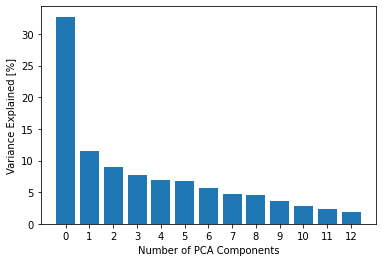

In [54]:
# refer to '15.4.3_3_Unsupervised Learning_Dimension reduction'
# refer to '15.6.3_Clustering Case Study - Customer Segmentation with K-Means - Tier 1'

# Create a PCA instance: pca
pca = PCA()

# Fit model to numeric features 
pca.fit(X_train_mean_scaled)

# Plot the explained variances
variance = pca.explained_variance_ratio_
plt.bar(range(len(variance)), variance*100)
plt.xlabel("Number of PCA Components")
plt.ylabel("Variance Explained [%]")
plt.xticks(range(len(variance)))
plt.show()

In [55]:
# Check how many pca components to include
variance[0:4].sum()*100, variance[0:5].sum()*100, variance[0:6].sum()*100, variance[0:7].sum()*100

(60.935554621935516, 67.81847465735652, 74.58079729774343, 80.29816763153919)

Some criteria say that the total variance explained by all components should be between 70% to 80% variance. 
- reference: https://stats.idre.ucla.edu/spss/seminars/efa-spss/

I decided to pick 4 pca components below by eyeballing, which ended up only explained 60% of variance. In order to explain 70%-80% variance, I should have picked 6-7 pca components to fit the model.

**Eyeballed Decision**: It looks like PCA features 0 have the most significant variance (first elbow). Will keep PCA features 0 - 3 (2nd elbow) for more variance to be conservative.

In [56]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_train_mean_scaled)

# Transform the numeric features: pca_features
pca_X_train_mean_scaled = pca.transform(X_train_mean_scaled)

# Print the shape of pca_features
print(pca_X_train_mean_scaled.shape)
print(type(pca_X_train_mean_scaled))
pca_X_train_mean_scaled = pd.DataFrame(pca_X_train_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_train_mean_scaled.head()

(5012, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-2.491191,-0.459051,1.182508,0.081856
1,-0.011536,1.268962,-0.139542,0.019501
2,-1.311341,-0.782541,-0.606125,-0.821669
3,0.022627,-0.192157,2.184337,0.431121
4,-0.386141,1.929972,-0.217576,0.681070


In [57]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_test_mean_scaled)

# Transform the numeric features: pca_features
pca_X_test_mean_scaled = pca.transform(X_test_mean_scaled)

# Print the shape of pca_features
print(pca_X_test_mean_scaled.shape)
print(type(pca_X_test_mean_scaled))
pca_X_test_mean_scaled = pd.DataFrame(pca_X_test_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_test_mean_scaled.head()

(1254, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-0.772253,-1.415618,1.773742,-0.246612
1,-0.169652,-1.219467,1.250325,0.200359
2,-2.660008,0.149781,1.212009,-2.183676
3,0.138555,-0.730671,1.873763,-1.039202
4,1.213567,1.276207,1.131137,0.812500


In [58]:
# Combine pca scaled features + dummy variabls + the original binary features
# pca_X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
# print(X_train_odmb.shape)
pca_X_train_mean_scaled_odmb = pd.merge(pca_X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(pca_X_train_mean_scaled_odmb.shape)
pca_X_train_mean_scaled_odmb.head() 

(5012, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-2.491191,-0.459051,1.182508,0.081856,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.011536,1.268962,-0.139542,0.019501,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-1.311341,-0.782541,-0.606125,-0.821669,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
3,0.022627,-0.192157,2.184337,0.431121,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,-0.386141,1.929972,-0.217576,0.681070,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [59]:
# pca_X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
# print(X_test_odmb.shape)
# X_train_odmb.head()
pca_X_test_mean_scaled_odmb = pd.merge(pca_X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(pca_X_test_mean_scaled_odmb.shape)
pca_X_test_mean_scaled_odmb.head() 

(1254, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.772253,-1.415618,1.773742,-0.246612,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.169652,-1.219467,1.250325,0.200359,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,-2.660008,0.149781,1.212009,-2.183676,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.138555,-0.730671,1.873763,-1.039202,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1.213567,1.276207,1.131137,0.812500,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.5 Fit Model 

In [60]:
# check the balance of origianl data.
# https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data
y.sum()/len(y)*100

42.770507500797954

Since the proportion of minority class is 42%, the degree of imbalance for this dataset can be considered as mild. The default model fitting metric, 'accuracy',  should be avoided to evaluate imbalance dataset. Instead, 'log loss' metric is recommended for imblance dataset. For our dataset, the degree of imbalance is mild so 'accuracy' should be ok but we will use **'log loss'** to train the models.

### 3.5.1 LogisticRegression via sklearn

In [61]:
# make sure the y input for sklearn model is 1d array
y_train.shape, y_test.shape

((5012,), (1254,))

In [62]:
# check possible range for c_space
np.logspace(-5, 8, 15)

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

#### 3.5.1.1 numeric features without PCA

Accuracy as training matric first to compare.

In [63]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg0 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://datascience.stackexchange.com/questions/94261/whats-the-default-scorer-in-sci-kit-learns-gridsearchcv
logreg_cv0 = GridSearchCV(logreg0, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv0.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv0.best_params_)) 
print("Best score is {}".format(logreg_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv0.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) #### depending on if we want higher precision or recall, we can add extra code here to bias our prediction to certatin ways.0.5

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred0))
print(classification_report(y_test, lg_y_pred0))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8314085687050625
Accuracy on training data: 0.86
Accuracy on test data:     0.82
[[617  97]
 [128 412]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       714
           1       0.81      0.76      0.79       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.82      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 19s


In [64]:
# check the data balance of prediction
540/(540+714)*100

43.0622009569378

Using accuracy as training metric, degree of imbalance in prediction is mild (43%).

Log loss as training matric.

In [65]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg0 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv0 = GridSearchCV(logreg0, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
logreg_cv0.fit(X_train_mean_scaled_odmb, y_train)
lgsk_train_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsk_train_run_time0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv0.best_params_)) 
print("Best score is {}".format(logreg_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv0.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) #### depending on if we want higher precision or recall, we can add extra code here to bias our prediction to certatin ways.0.5

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred0))
print(classification_report(y_test, lg_y_pred0))

training run time:  0:01:26.049874
Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is -0.38076489959393633
Accuracy on training data: 0.86
Accuracy on test data:     0.82
[[617  97]
 [128 412]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       714
           1       0.81      0.76      0.79       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.82      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 26s


In [66]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg1 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45)
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv1 = GridSearchCV(logreg1, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
logreg_cv1.fit(X_train_mean_scaled_odmb, y_train)
lgsk_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsk_train_run_time1)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv1.best_params_)) 
print("Best score is {}".format(logreg_cv1.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best1 = logreg_cv1.best_estimator_
training_accuracy = logreg_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Predict the labels of the test data: y_pred
lg_y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb)

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred1))
print(classification_report(y_test, lg_y_pred1))

training run time:  0:45:55.862572
Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.2, 'penalty': 'elasticnet'}
Best score is -0.3499249445451534
Accuracy on training data: 0.86
Accuracy on test data:     0.83
[[635  79]
 [140 400]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       714
           1       0.84      0.74      0.79       540

    accuracy                           0.83      1254
   macro avg       0.83      0.82      0.82      1254
weighted avg       0.83      0.83      0.82      1254

Wall time: 45min 55s


#### 3.5.1.2 numeric features with PCA

In [67]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best2 = logreg_cv.best_estimator_
training_accuracy = logreg_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred2 = logreg_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Best score is -0.3947070313956276
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[608 106]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 1min 41s


In [68]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1) #%%%%% should pick range around 0.5 for better training!!
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best3 = logreg_cv.best_estimator_
training_accuracy = logreg_best3.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best3.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred3 = logreg_best3.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is -0.3683648314137616
Accuracy on training data: 0.84
Accuracy on test data:     0.81
[[625  89]
 [149 391]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       714
           1       0.81      0.72      0.77       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 45min 31s


### 3.5.2 LogisticRegression via statsmodels

#### 3.5.2.1 numeric features without PCA

Higher the Pseudo R-squ.score, the better the model is. Adding constant may improve the Pseudo R-squ.

In [69]:
%%time
# statsmodel w/ constant & penalty term
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
X_train_mean_scaled_odmb_c = sm.add_constant(X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
X_test_mean_scaled_odmb_c = sm.add_constant(X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
X_train_mean_scaled_odmb_c_dirty = X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(X_train_mean_scaled_odmb_c.shape[0], X_train_mean_scaled_odmb_c.shape[1])
X_test_mean_scaled_odmb_c_dirty = X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(X_test_mean_scaled_odmb_c.shape[0], X_test_mean_scaled_odmb_c.shape[1])

# Fit it to the data
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
start_time = datetime.datetime.now() #%%%% need to put this right before
log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)
lgsm_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsm_train_run_time1)

# Predict the labels of the test data: y_pred
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)


# check statsmodel prediction
# print(type(y_pred1))
# print(y_pred1)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred1_df = pd.DataFrame({'probability': y_pred1})
# print(y_pred1_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 
#%%%% y_pred1_df.prediction = [list comprehenshion] did not work!
# print(y_pred1_df) 

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1_df.prediction))
print(classification_report(y_test, y_pred1_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.30695391479589607
            Iterations: 637
            Function evaluations: 637
            Gradient evaluations: 637
training run time:  0:01:25.631077
[[615  99]
 [129 411]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       714
           1       0.81      0.76      0.78       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.81      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 25s


In [70]:
# printing the summary table 
log_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4773
Method:                           MLE   Df Model:                          238
Date:                Fri, 26 Nov 2021   Pseudo R-squ.:                  0.5502
Time:                        04:01:21   Log-Likelihood:                -1538.5
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.4663      1.363     -1.809      0.070      -5.139       0.206
age                                                                0.0150      0.086      0.175      0.861      -0.154       0.184
int_corr                                                           0.0284      0.051      0.561      0.575      -0.071       0.128
imprace                                                            0.0795      0.072      1.103      0.270      -0.062       0.221
imprelig                                                           0.0314      0.069      0.454      0.650      -0.104       0.167
age_o                                                              0.0667      0.049      1.373      0.170      -0.029       0.162
attr_o                                                             0.9607      0.078     12.239      0.000       0.807       1.115
sinc_o                                                            -0.3293      0.074     -4.471      0.000      -0.474      -0.185
intel_o                                                           -0.0663      0.080     -0.830      0.407      -0.223       0.090
fun_o                                                              0.1398      0.079      1.769      0.077      -0.015       0.295
amb_o                                                             -0.1876      0.069     -2.700      0.007      -0.324      -0.051
shar_o                                                             0.0993      0.068      1.462      0.144      -0.034       0.232
like_o                                                             1.1084      0.094     11.752      0.000       0.924       1.293
prob_o                                                             0.4107      0.059      6.985      0.000       0.295       0.526
race_1.0                                                          -1.7601   4706.153     -0.000      1.000   -9225.650    9222.130
race_2.0                                                          -1.5742   4706.155     -0.000      1.000   -9225.469    9222.321
race_3.0                                                          -2.0452   4706.153     -0.000      1.000   -9225.935    9221.845
race_4.0                                                          -2.0463   4706.153     -0.000      1.000   -9225.936    9221.844
race_6.0                                                          -1.8794   4706.153     -0.000      1.000   -9225.769    9222.010
field_American Studies                                             1.2946   1130.629      0.001      0.999   -2214.698    2217.287
field_American Studies (Masters)                                  -0.4594   1130.630     -0.000      1.000   -2216.453    2215.534
field_Anthropology                                               -12.4534   1343.196     -0.009  

Overall scores are little lower than sklearn model but runs much faster (due to no crossvalidation available)

#### 3.5.2.2 numeric features with PCA

In [71]:
%%time
# statsmodel w/ constant & penalty term
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
pca_X_train_mean_scaled_odmb_c = sm.add_constant(pca_X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
pca_X_test_mean_scaled_odmb_c = sm.add_constant(pca_X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
pca_X_train_mean_scaled_odmb_c_dirty = pca_X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_train_mean_scaled_odmb_c.shape[0], pca_X_train_mean_scaled_odmb_c.shape[1])
pca_X_test_mean_scaled_odmb_c_dirty = pca_X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_test_mean_scaled_odmb_c.shape[0], pca_X_test_mean_scaled_odmb_c.shape[1])

# Fit it to the data
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg2 = sm.Logit(y_train, pca_X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

# Predict the labels of the test data: y_pred
y_pred2 = log_reg2.predict(pca_X_test_mean_scaled_odmb_c_dirty)
# print(type(y_pred2))
# print(y_pred2)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred2_df = pd.DataFrame({'probability': y_pred2})
# print(y_pred2_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred2_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred2_df.probability] 
#%%%% y_pred2_df.prediction = [list comprehenshion] did not work!
# y_pred2_df 

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2_df.prediction))
print(classification_report(y_test, y_pred2_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32450870676108157
            Iterations: 623
            Function evaluations: 624
            Gradient evaluations: 623
[[607 107]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.80      0.81      0.80      1254

Wall time: 1min 14s


In [72]:
# printing the summary table 
log_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4782
Method:                           MLE   Df Model:                          229
Date:                Fri, 26 Nov 2021   Pseudo R-squ.:                  0.5245
Time:                        04:02:35   Log-Likelihood:                -1626.4
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.4585      1.368     -1.797      0.072      -5.140       0.223
pca0                                                              -0.7298      0.033    -22.430      0.000      -0.794      -0.666
pca1                                                               0.2412      0.051      4.734      0.000       0.141       0.341
pca2                                                              -0.1066      0.052     -2.060      0.039      -0.208      -0.005
pca3                                                              -0.8640      0.059    -14.760      0.000      -0.979      -0.749
race_1.0                                                          -2.6678   4505.773     -0.001      1.000   -8833.821    8828.485
race_2.0                                                          -2.4937   4505.777     -0.001      1.000   -8833.654    8828.667
race_3.0                                                          -2.9615   4505.774     -0.001      0.999   -8834.116    8828.193
race_4.0                                                          -3.2025   4505.779     -0.001      0.999   -8834.367    8827.962
race_6.0                                                          -3.0420   4505.782     -0.001      0.999   -8834.213    8828.129
field_American Studies                                             2.5795   1172.586      0.002      0.998   -2295.647    2300.806
field_American Studies (Masters)                                   1.0037   1172.590      0.001      0.999   -2297.231    2299.239
field_Anthropology                                               -12.6166   1978.021     -0.006      0.995   -3889.467    3864.234
field_Applied Maths/Econs                                          4.7400   1172.610      0.004      0.997   -2293.533    2303.013
field_Applied Physiology & Nutrition                               2.5993   1172.611      0.002      0.998   -2295.676    2300.874
field_Architecture                                                 1.7540   1172.613      0.001      0.999   -2296.525    2300.033
field_Art Education                                                2.1417   1172.581      0.002      0.999   -2296.075    2300.359
field_Art History                                                  2.3043   1172.600      0.002      0.998   -2295.949    2300.558
field_Art History/medicine                                         3.9672   1172.526      0.003      0.997   -2294.142    2302.076
field_Arts Administration                                          3.3656   1172.565      0.003      0.998   -2294.819    2301.550
field_BUSINESS CONSULTING                                          4.0516   1172.592      0.003      0.997   -2294.186    2302.289
field_Bilingual Education                                          3.5073   1172.572      0.003  

Without PCA restulted in slightly better scores overall than with PCA with comparable running time. Will use numeric features without PCA for further analysis.

### 3.5.3 Random Forest via sklearn

#### 3.5.3.1 numeric features without PCA

In [73]:
%%time
# refer to '14.3.5_Case Study - Decision Trees - RR Diner Coffee'

# Optimize max_depth=n (3-10?) %%%% which parameter to optimize? n_estimators? (100-300) using GridSearch?
# Plug in appropriate max_depth and random_state parameters 
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'
rfc = RandomForestClassifier(criterion='gini', max_depth=3, random_state = 1234) #%%%%% from previous best model!??

# Model and fit
rfc.fit(X_train_mean_scaled_odmb, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = rfc.predict(X_test_mean_scaled_odmb)

# compute accuracy of train set and test set
training_accuracy = rfc.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training data: 0.80
Accuracy on test data:     0.77
[[639  75]
 [216 324]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       714
           1       0.81      0.60      0.69       540

    accuracy                           0.77      1254
   macro avg       0.78      0.75      0.75      1254
weighted avg       0.78      0.77      0.76      1254

Wall time: 392 ms


In [74]:
%%time
# start with small number of trees (n_estimators = [ 50, 100, 150, 200])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(50,250,50) # array([ 50, 100, 150, 200])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv = GridSearchCV(rfc, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best score is -0.4500230480614199
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[620  94]
 [151 389]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       714
           1       0.81      0.72      0.76       540

    accuracy                           0.80      1254
   macro avg       0.80      0.79      0.80      1254
weighted avg       0.80      0.80      0.80      1254

Wall time: 1min 29s


Efficient model: running time within 10min! since 200 trees was the best, will increase the tree number.

In [75]:
%%time
# Increase the number of trees (n_estimators = [200, 300, 400, 500])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(200,600,100) # array([200, 300, 400, 500])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc0 = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv0 = GridSearchCV(rfc0, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_cv0.fit(X_train_mean_scaled_odmb, y_train)
rfc_train_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', rfc_train_run_time0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv0.best_params_)) 
print("Best score is {}".format(rfc_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best0 = rfc_cv0.best_estimator_
training_accuracy = rfc_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
rfc_y_pred0 = rfc_best0.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred0))
print(classification_report(y_test, rfc_y_pred0))

training run time:  0:04:00.185198
Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score is -0.44885410287099486
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[627  87]
 [152 388]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       714
           1       0.82      0.72      0.76       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 4min


Since 500 trees was the best, will increase the tree number.

In [76]:
%%time
# Increase the number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc1 = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv1 = GridSearchCV(rfc1, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_cv1.fit(X_train_mean_scaled_odmb, y_train)
rfc_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', rfc_train_run_time1)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv1.best_params_)) 
print("Best score is {}".format(rfc_cv1.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best1 = rfc_cv.best_estimator_
training_accuracy = rfc_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
rfc_y_pred1 = rfc_best1.predict(X_test_mean_scaled_odmb)


# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred1))
print(classification_report(y_test, rfc_y_pred1))

training run time:  0:12:39.894065
Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 600}
Best score is -0.44826546517942223
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[620  94]
 [151 389]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       714
           1       0.81      0.72      0.76       540

    accuracy                           0.80      1254
   macro avg       0.80      0.79      0.80      1254
weighted avg       0.80      0.80      0.80      1254

Wall time: 12min 40s


#### 3.5.3.1 numeric features with PCA

In [77]:
%%time
# Start with the large number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv = GridSearchCV(rfc, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
rfc_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best2 = rfc_cv.best_estimator_
training_accuracy = rfc_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
rfc_y_pred2 = rfc_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred2))
print(classification_report(y_test, rfc_y_pred2))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score is -0.5048858484308361
Accuracy on training data: 0.81
Accuracy on test data:     0.79
[[676  38]
 [228 312]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       714
           1       0.89      0.58      0.70       540

    accuracy                           0.79      1254
   macro avg       0.82      0.76      0.77      1254
weighted avg       0.81      0.79      0.78      1254

Wall time: 12min 43s


numeric features with PCA gave noticeably lower overall scores than numeric features without PCA. Since running time is about the same, will use numeric features without PCA for further analysis.

## 3.6 Model Evaluation

### 3.6.1 Fit Null Model

To check the base of each model using fitting null models.

The baseline of comparison, the null model, is a model with no X variables such that the fitted value for each set of X values is the mean of response variable y. The corresponding slope intercept is the mean of y, and the standard deviation of the residuals is the standard deviation of y.
- referece: https://cran.r-project.org/web/packages/lessR/vignettes/Regression.html#null-model

In [78]:
# Check the Mean of target, train and test dataset
print('Mean of target train dataset: ', y_train.mean())
print('Mean of target test dataset: ', y_test.mean())

Mean of target train dataset:  0.42697525937749403
Mean of target test dataset:  0.430622009569378


#### 3.6.1.1 logistic regreassion via sklearn

In [79]:
# code by Julian
# naive model: random guesses using the intercept
# use default params for regression
X_null_train = np.ones(shape=y_train.shape[0]).reshape(-1,1) # intercept
X_null_test = np.ones(shape=y_test.shape[0]).reshape(-1,1) # intercept

# logistic regreassion via sklearn
null_lgsk = LogisticRegression(fit_intercept=False) 
# fit on train and test data
null_train_lgsk = null_lgsk.fit(X=X_null_train, y=y_train)
null_test_lgsk = null_lgsk.fit(X=X_null_test, y=y_test)

null_train_pred_lgsk = null_train_lgsk.predict(X_null_train)
null_test_pred_lgsk = null_test_lgsk.predict(X_null_test)

In [80]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_lgsk))
print(classification_report(y_train, null_train_pred_lgsk))

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [81]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_lgsk))
print(classification_report(y_test, null_test_pred_lgsk))

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254



#### 3.6.1.2 logistic regreassion via stasmodel

In [82]:
# logistic regreassion via stasmodel
# log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized()
# fit on train and test data
null_train_lgsm = sm.Logit(y_train, X_null_train).fit_regularized() # do I need to add constant?
null_test_lgsm = sm.Logit(y_test, X_null_test).fit_regularized()

# y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)
null_train_pred_lgsm = null_train_lgsm.predict(X_null_train) # need to convert this probability to binanry prediction
null_test_pred_lgsm = null_test_lgsm.predict(X_null_test)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
null_train_pred_lgsm_df = pd.DataFrame({'probability': null_train_pred_lgsm})
null_train_pred_lgsm_df['prediction'] = [0 if row < 0.5 else 1 for row in null_train_pred_lgsm_df.probability] 

null_test_pred_lgsm_df = pd.DataFrame({'probability': null_test_pred_lgsm})
null_test_pred_lgsm_df['prediction'] = [0 if row < 0.5 else 1 for row in null_test_pred_lgsm_df.probability] 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6824437121518183
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.683489438523392
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5


In [83]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_lgsm_df.prediction))
print(classification_report(y_train, null_train_pred_lgsm_df.prediction))

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012



In [84]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_lgsm_df.prediction))
print(classification_report(y_test, null_test_pred_lgsm_df.prediction))

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254



#### 3.6.1.3 Random forest model via sklearn

In [85]:
# Random forest model via sklearn
# rfc0 = RandomForestClassifier(random_state = 1234)
null_rfc = RandomForestClassifier() #%%%% removed fit_intercept=False
# fit on train and test data
null_train_rfc = null_rfc.fit(X=X_null_train, y=y_train)
null_test_rfc = null_rfc.fit(X=X_null_test, y=y_test)

null_train_pred_rfc = null_train_rfc.predict(X_null_train)
null_test_pred_rfc = null_test_rfc.predict(X_null_test)

In [86]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_rfc))
print(classification_report(y_train, null_train_pred_rfc))

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [87]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_rfc))
print(classification_report(y_test, null_test_pred_rfc))

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254



### 3.6.2 Threshold Analysis and Predicted Probabilites Distribution

**Threshold analysis** will be performed to select the threshold that maximizes the matric of interest (TBD). Threshold analysis is only done on the training data. After selecting the threshold, we want to see how well our model generalizes on the test data. So we need to find the probability value that maximizes our metric of interest, then use that to make binary values as our test predictions to evaluate our confusion matrix, etc.

General workflow of threshold analysis:
1. Define set of linearly spaced values to search over
2. Get the precision, recall, and F1 scores from the probability predictions on train dataset
3. Find the probability that gives the maximum metric of interest (threshold)
4. Create binary prediction on test dataset using the threshold probability that you found 

**Predicted probabilities distribution** for each model will be plotted to check if there is a clear separation in prediction. 

In [88]:
# code provided by mentor, Julian
def threshold_and_plot(y_test, target, n_points=50, plot=True):
    """
    :param y_test: binary vector of actual targets #%%%%% y_train
    :param target: vector of probabilities #%%%%% predicted from model
    :param n_points: number of points to evaluate for a threshold
    :param plot: Boolean; whether or not to plot the results
    :return: vector of values of precision, recall, F1 for given points
    """
    # plot the value of the metric against the threshold
    # plt.figure(figsize=(12,12))
    probs = np.linspace(0, 1, n_points)
    def make_thresh():  # try n_points = 50 or 100...
        # calculate each metric here
        precision = [metrics.precision_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        recall = [metrics.recall_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        f1 = [metrics.f1_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        return precision, recall, f1

    precision, recall, f1 = make_thresh()
    if plot:
        plt.plot(probs, precision, label='precision')
        plt.plot(probs, recall, label='recall')
        plt.plot(probs, f1, label='f1')
        plt.title("Metrics at various thresholds");
        plt.xlabel("Probability");
        plt.ylabel("Metric value");
        plt.legend();
        # print("Precision: {:.3f}; Recall: {:.3f}; F1: {:.3f}".format(precision, recall, f1))
        return precision, recall, f1
    else:
        return precision, recall, f1

def max_thresh(score_vec):
    max_idx = np.argmax(score_vec)
    max_score = score_vec[max_idx]
    return max_idx, max_score

In [89]:
# function to....
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.

def prob_dist_plot(target, prob, bins=10):
    # plot observed data
    df = pd.DataFrame({"Observed": target, "Probability": prob})
    sns.histplot(data=df, x="Probability", hue="Observed", bins=bins).set(title='Predicted Probabilities Distribution');


#### 3.6.2.1 Test random data

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.693


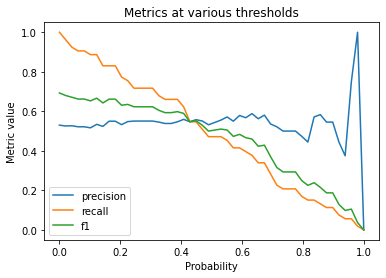

In [90]:
# Test random data
y_test_random=  np.random.choice([0, 1], 100, replace=True)
test_random_prob = np.random.uniform(0., 1., 100)
test_random_thresh = threshold_and_plot(y_test_random, test_random_prob, 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], test_random_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

#### 3.6.2.2 logistic regreassion via sklearn

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.835
prediction run time:  0:00:00.005002


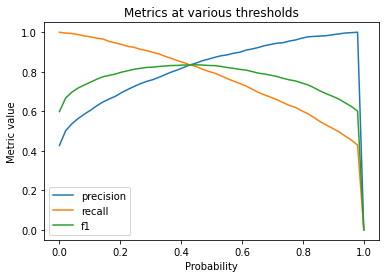

In [91]:
# logistic regreassion via sklearn 1
# Threshold analysis on train dataset
# predicting probabilities
#%%%% lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb)
#%%%% The predict() method gives binary values (using a default of p > 0.5 = 1) instead of probabilities 
'''
https://www.kaggle.com/c/dont-overfit-ii/discussion/90656
The function predict_proba() returns a numpy array of two columns. 
The first column is the probability that target=0 and the second column is the probability that target=1. 
That is why we add [:,1] after predict_proba() in order to get the probabilities of target=1.
'''
lg_y_train_pred0 = logreg_best0.predict(X_train_mean_scaled_odmb)
lg_y_train_prob0 = logreg_best0.predict_proba(X_train_mean_scaled_odmb)
logreg0_train_thresh = threshold_and_plot(y_train, lg_y_train_prob0[:,1], 50)
#logreg0_thresh = threshold_and_plot(y_test, lg_y_prob0[:,1], 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], logreg0_train_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")
    
# Test dataset
start_time = datetime.datetime.now() #%%%% need to put this right before
lg_y_prob0 = logreg_best0.predict_proba(X_test_mean_scaled_odmb)
lgsk_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsk_run_time0)
#lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) #### depending on if we want higher precision or recall, we can add extra code here to bias our prediction to certatin ways.0.5

We need to pick precision, recall or f1 to perform the model evaluation based on description below.
- **Precision** is a good metric to use when the cost of **False Positive** is high
- **Recall/sensitivity** is a good metric to use when the cost of **False Negative** is high
- **F1** is a good metic to use than accuracy when we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

referene: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

To predict matching dates (who possibly like each other), I think that you don’t want to miss true positives and risk of false positive predictions should be low. Therefore, I would like to choose **Recall** to maximize for model evaluation.

In [92]:
# find the probability value that maximizes your metric of interest: recall
probs = np.linspace(0, 1, 50)
lg_max_rec_prob0 = probs[np.argmax(logreg0_train_thresh[1])]
lg_max_rec_prob0

0.0

However, as you can see above the probability value that maximizes my metric of interest, **Recall**, is **0**. If I use **0** to make binary predictions on test dataset, it will be too extreme and not a ideal threshold. Therefore, I will pick **f1** as matric to moazimize for model evalutation instead.

In [93]:
# find the probability value that maximizes your metric of interest: f1
lg_max_f1_prob0 = probs[np.argmax(logreg0_train_thresh[2])]
print('probability with Max f1: ', lg_max_f1_prob0)
# Create binary value predictions on test dataset based off of the probability that you found
lg_y_pred0_f1_thresh = np.where(lg_y_prob0[:,1] > lg_max_f1_prob0, 1, 0)
# Note: lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) uses default threshold 0.5 to create binary values from probabilities

probability with Max f1:  0.44897959183673464


Will use the binary prediction created with adjusted threshold to run confusion matrix, classification report, etc in the model evaluation later.

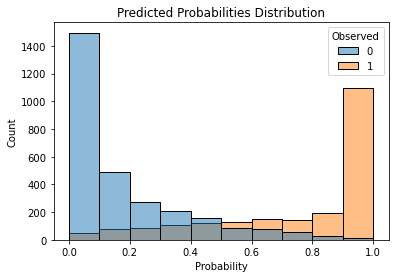

In [94]:
# check the distributions of predicted values (probabilities) on both train & test dataset
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
# Train dataset
prob_dist_plot(y_train, lg_y_train_prob0[:,1])

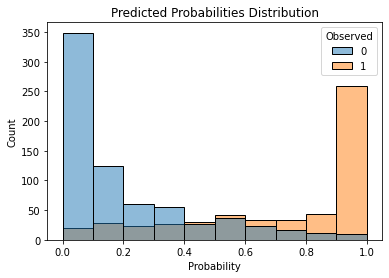

In [95]:
# Test dataset
prob_dist_plot(y_test, lg_y_prob0[:,1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.828
prediction run time:  0:00:00.003999
probability with Max f1:  0.4081632653061224


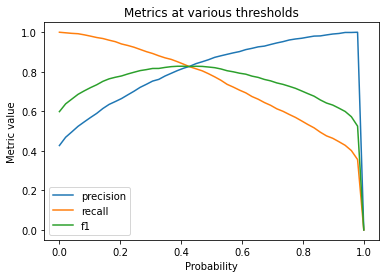

In [96]:
# logistic regreassion via sklearn 2
# Treshold analysis on train dataset
# Train dataset
lg_y_train_pred1 = logreg_best1.predict(X_train_mean_scaled_odmb)
lg_y_train_prob1 = logreg_best1.predict_proba(X_train_mean_scaled_odmb)
logreg1_train_thresh = threshold_and_plot(y_train, lg_y_train_prob1[:,1], 50)
# #logreg1_thresh = threshold_and_plot(y_test, lg_y_prob1[:,1], 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], logreg1_train_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

# Test dataset
start_time = datetime.datetime.now() #%%%% need to put this right before
lg_y_prob1 = logreg_best1.predict_proba(X_test_mean_scaled_odmb)
lgsk_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsk_run_time1)

# find the probability value that maximizes your metric of interest: f1
lg_max_f1_prob1 = probs[np.argmax(logreg1_train_thresh[2])]
print('probability with Max f1: ', lg_max_f1_prob1)

# Create binary value predictions on test dataset based off of the probability that you found
lg_y_pred1_f1_thresh = np.where(lg_y_prob1[:,1] > lg_max_f1_prob1, 1, 0)
# Note: lg_y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb) uses default threshold 0.5 to create binary values from probabilities

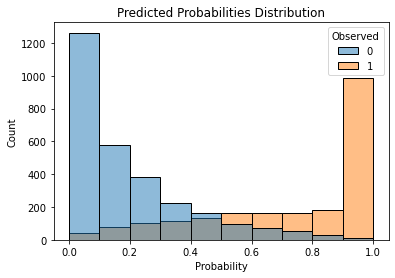

In [97]:
# check the distributions of predicted values (probabilities) on both train & test dataset
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
# Train dataset
prob_dist_plot(y_train, lg_y_train_prob1[:,1])

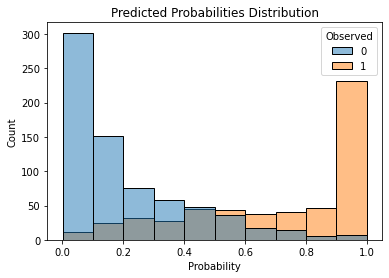

In [98]:
# Test dataset
prob_dist_plot(y_test, lg_y_prob1[:,1])

#### 3.6.2.3 logistic regreassion via statsmodel

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.836
prediction run time:  0:00:00.000999
probability with Max f1:  0.44897959183673464


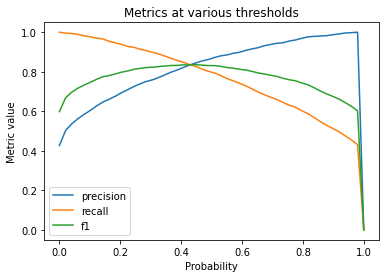

In [99]:
# logistic regreassion via statsmodel
# Treshold analysis on train dataset
#%%%%% how to get probability for statsmodel? > 
# y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty) > the default output of statsmodel predict is 'probability'

# Train dataset
y_train_pred1 = log_reg1.predict(X_train_mean_scaled_odmb_c_dirty)
lgsm_train_thresh = threshold_and_plot(y_train, y_train_pred1, 50) # y_pred1_df.prediction.shape, y_pred1.shape > (1254,)
#lgsm_thresh = threshold_and_plot(y_test, y_pred1, 50) # y_pred1_df.prediction.shape, y_pred1.shape > (1254,)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], lgsm_train_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")
    
# Test dataset
start_time = datetime.datetime.now() #%%%% need to put this right before
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)
lgsm_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsm_run_time1)

# find the probability value that maximizes your metric of interest: f1
lgsm_max_f1_prob1 = probs[np.argmax(lgsm_train_thresh[2])]
print('probability with Max f1: ', lgsm_max_f1_prob1)

# Create binary value predictions on test dataset based off of the probability that you found
lgsm_y_pred1_f1_thresh = np.where(y_pred1 > lgsm_max_f1_prob1, 1, 0)
# Note: y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 

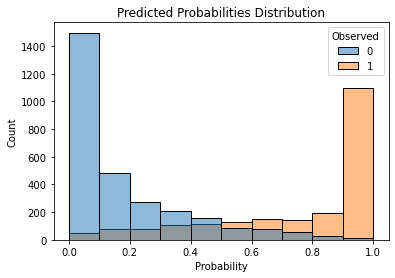

In [100]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
# Train dataset
prob_dist_plot(y_train, y_train_pred1)

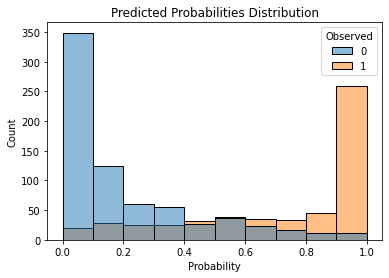

In [101]:
# Test dataset
prob_dist_plot(y_test, y_pred1)

#### 3.6.2.4 Random forest model via sklearn

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.816
prediction run time:  0:00:00.098007
probability with Max f1:  0.4693877551020408


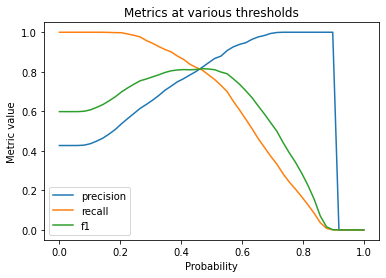

In [102]:
# Random forest model 1
# Treshold analysis on train dataset
rfc_y_train_pred0 = rfc_best0.predict(X_train_mean_scaled_odmb)
rfc_y_train_prob0 = rfc_best0.predict_proba(X_train_mean_scaled_odmb)
rfc0_train_thresh = threshold_and_plot(y_train, rfc_y_train_prob0[:,1], 50)
#rfc0_thresh = threshold_and_plot(y_test, rfc_y_prob0[:,1], 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], rfc0_train_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

# Test dataset
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_y_prob0 = rfc_best0.predict_proba(X_test_mean_scaled_odmb)
rfc_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', rfc_run_time0)

# find the probability value that maximizes your metric of interest: f1
rfc_max_f1_prob0 = probs[np.argmax(rfc0_train_thresh[2])]
print('probability with Max f1: ', rfc_max_f1_prob0)

# Create binary value predictions on test dataset based off of the probability that you found
rfc_y_pred0_f1_thresh = np.where(rfc_y_prob0[:,1] > rfc_max_f1_prob0, 1, 0)

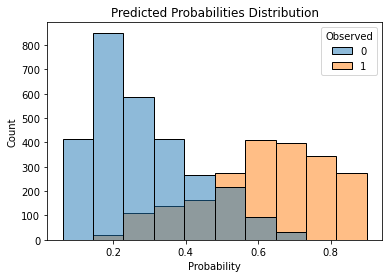

In [103]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
# Train dataset
prob_dist_plot(y_train, rfc_y_train_prob0[:,1])

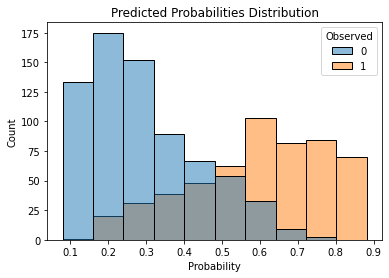

In [104]:
# Test dataset
prob_dist_plot(y_test, rfc_y_prob0[:,1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.815
prediction run time:  0:00:00.044001
probability with Max f1:  0.4693877551020408


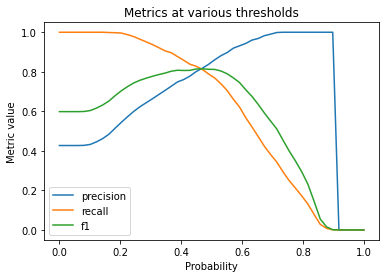

In [105]:
# Random forest model 2
# Threshold analysis
rfc_y_train_pred1 = rfc_best1.predict(X_train_mean_scaled_odmb)
rfc_y_train_prob1 = rfc_best1.predict_proba(X_train_mean_scaled_odmb)
rfc1_train_thresh = threshold_and_plot(y_train, rfc_y_train_prob1[:,1], 50)
#rfc1_thresh = threshold_and_plot(y_test, rfc_y_prob1[:,1], 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], rfc1_train_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

# Test dataset
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_y_prob1 = rfc_best1.predict_proba(X_test_mean_scaled_odmb)
rfc_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', rfc_run_time1)

# find the probability value that maximizes your metric of interest: f1
rfc_max_f1_prob1 = probs[np.argmax(rfc1_train_thresh[2])]
print('probability with Max f1: ', rfc_max_f1_prob1)

# Create binary value predictions on test dataset based off of the probability that you found
rfc_y_pred1_f1_thresh = np.where(rfc_y_prob1[:,1] > rfc_max_f1_prob1, 1, 0)

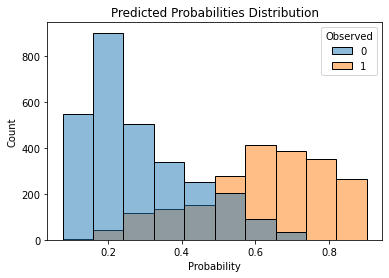

In [106]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
# Train dataset
prob_dist_plot(y_train, rfc_y_train_prob1[:,1])

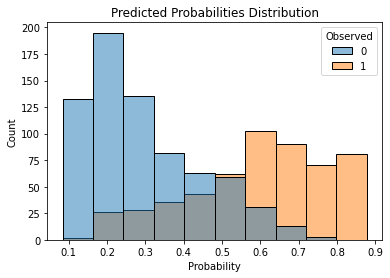

In [107]:
# Test dataset
prob_dist_plot(y_test, rfc_y_prob1[:,1])

Using the binary prediction created with adjusted threshold obtained from all the model candidates in this section, we will run confusion matrix, classification report, etc to evaluate each model in next section.

Predicted Prababilities Distribution plots showed clearer separaton of prediction in logistic regression models than random forest models.

### 3.6.3 Classification Report, Run time, and Size Comparison of each Model

Compare the pre-selected model from logistic regression via skelarn and statsmodel and Random Forest via sklearn in terms of evaluation metrics (classification report), computational complexity (runnig time), and scalability & maintenance costs (model sizse).

In [108]:
# convert Scikit Learn Classification Report to Dataframe
# refer to 'https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5'
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [109]:
# to measure model size
# refer to 'https://www.kite.com/python/docs/sys.getsizeof'
lgsk_size0 = sys.getsizeof(pickle.dumps(logreg_cv0)) #%%%% Return the size of an object in bytes
lgsk_size1 = sys.getsizeof(pickle.dumps(logreg_cv1))
lgsm_size1 = sys.getsizeof(pickle.dumps(log_reg1))  
rfc_size0 = sys.getsizeof(pickle.dumps(rfc_cv0)) #%%%%%% rfc should have larger size than lg. 
rfc_size1 = sys.getsizeof(pickle.dumps(rfc_cv1))
#%%%% print(sys.getsizeof(X)) is not the right way to calculate the accurate size because all gave '48' as output
#%%%% rfc should have larger size than lg. 
#%%%% X = logreg0, logreg1, rfc0, rfc1, logreg_cv0, logreg_cv1, rfc_cv0, rfc_cv1


#### 3.6.3.1 logistic regreassion via sklearn

In [110]:
# logistic regreassion via sklearn 1
print('training run time: ', lgsk_train_run_time0)
print('prediction run time: ', lgsk_run_time0)
print('model size: ', lgsk_size0)
lgsk_report0_df =  get_classification_report(y_test, lg_y_pred0_f1_thresh) 
lgsk_report0_df

training run time:  0:01:26.049874
prediction run time:  0:00:00.005002
model size:  4835


,precision,recall,f1-score,support
0,0.839833,0.844538,0.842179,714.000000
1,0.792910,0.787037,0.789963,540.000000
accuracy,0.819777,0.819777,0.819777,0.819777
macro avg,0.816372,0.815787,0.816071,1254.000000
weighted avg,0.819627,0.819777,0.819693,1254.000000


In [111]:
# logistic regreassion via sklearn 2
print('training run time: ', lgsk_train_run_time1)
print('prediction run time: ', lgsk_run_time1)
print('model size: ', lgsk_size1)
lgsk_report1_df  =  get_classification_report(y_test, lg_y_pred1_f1_thresh)
lgsk_report1_df 

training run time:  0:45:55.862572
prediction run time:  0:00:00.003999
model size:  23000


,precision,recall,f1-score,support
0,0.858177,0.830532,0.844128,714.000000
1,0.785080,0.818519,0.801451,540.000000
accuracy,0.825359,0.825359,0.825359,0.825359
macro avg,0.821628,0.824525,0.822789,1254.000000
weighted avg,0.826700,0.825359,0.825750,1254.000000


#### 3.6.3.2 logistic regreassion via statsmodel

In [112]:
# logistic regreassion via statsmodel
print('training run time: ', lgsm_train_run_time1)
print('prediction run time: ', lgsm_run_time1)
print('model size: ', lgsm_size1)
lgsm_report1_df =  get_classification_report(y_test, lgsm_y_pred1_f1_thresh)
lgsm_report1_df

training run time:  0:01:25.631077
prediction run time:  0:00:00.000999
model size:  19722725


,precision,recall,f1-score,support
0,0.839385,0.841737,0.840559,714.000000
1,0.789963,0.787037,0.788497,540.000000
accuracy,0.818182,0.818182,0.818182,0.818182
macro avg,0.814674,0.814387,0.814528,1254.000000
weighted avg,0.818103,0.818182,0.818140,1254.000000


#### 3.6.3.3 Random forest model via sklearn

In [113]:
# Random forest model 1
print('training run time: ', rfc_train_run_time0)
print('prediction run time: ', rfc_run_time0)
print('model size: ', rfc_size0)
rfc_report0_df =  get_classification_report(y_test, rfc_y_pred0_f1_thresh)
rfc_report0_df

training run time:  0:04:00.185198
prediction run time:  0:00:00.098007
model size:  4456616


,precision,recall,f1-score,support
0,0.828571,0.852941,0.840580,714.000000
1,0.797688,0.766667,0.781870,540.000000
accuracy,0.815789,0.815789,0.815789,0.815789
macro avg,0.813130,0.809804,0.811225,1254.000000
weighted avg,0.815272,0.815789,0.815298,1254.000000


In [114]:
# Random forest model 2
print('training run time: ', rfc_train_run_time1)
print('prediction run time: ', rfc_run_time1)
print('model size: ', rfc_size1)
rfc_report1_df =  get_classification_report(y_test, rfc_y_pred1_f1_thresh)
rfc_report1_df 

training run time:  0:12:39.894065
prediction run time:  0:00:00.044001
model size:  5927796


,precision,recall,f1-score,support
0,0.823045,0.840336,0.831601,714.00000
1,0.782857,0.761111,0.771831,540.00000
accuracy,0.806220,0.806220,0.806220,0.80622
macro avg,0.802951,0.800724,0.801716,1254.00000
weighted avg,0.805739,0.806220,0.805863,1254.00000


#### 3.6.3.4 Summary of all five models in terms of F1, Recall, Precision (of positive outcome (1) = want to date), Size of Model, Training and Prediction Running time

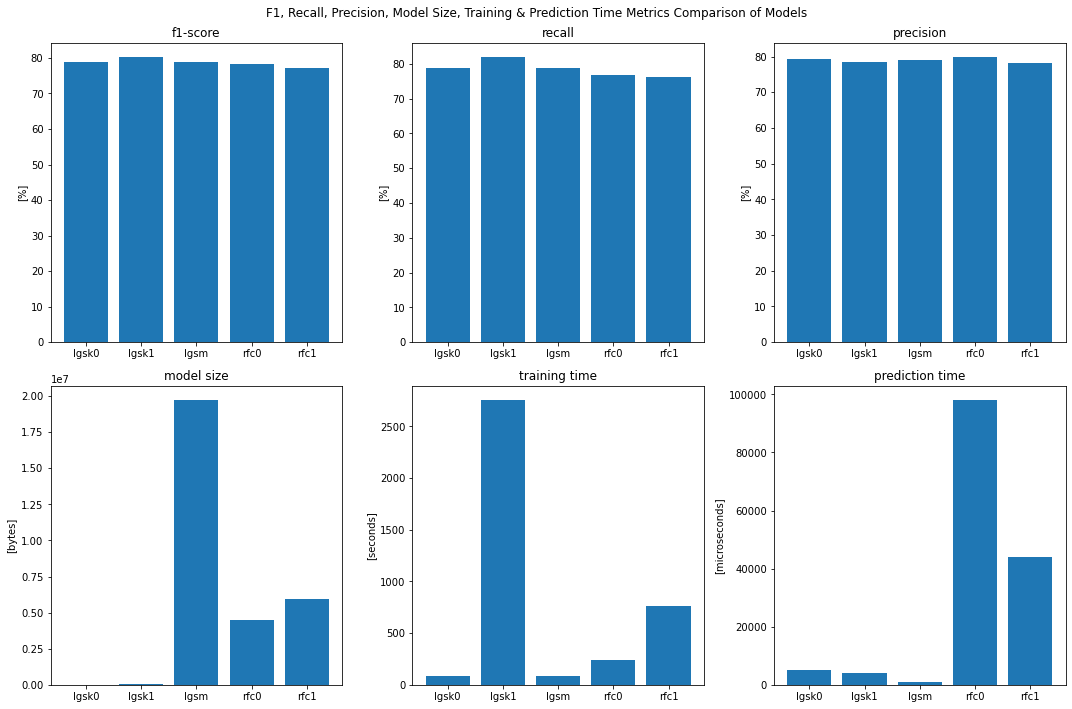

In [115]:
# Summary of all five models in terms of F1, Recall, Precision, Size of Model, Training and Prediction Running time
Model_list = ['lgsk0', 'lgsk1', 'lgsm', 'rfc0', 'rfc1']
F1_list = [lgsk_report0_df.loc['1', 'f1-score'], 
               lgsk_report1_df.loc['1', 'f1-score'], 
               lgsm_report1_df.loc['1', 'f1-score'], 
               rfc_report0_df.loc['1', 'f1-score'], 
               rfc_report1_df.loc['1', 'f1-score']]

# check the recall of each model 
Recall_list = [lgsk_report0_df.loc['1', 'recall'], 
               lgsk_report1_df.loc['1', 'recall'], 
               lgsm_report1_df.loc['1', 'recall'], 
               rfc_report0_df.loc['1', 'recall'], 
               rfc_report1_df.loc['1', 'recall']]

# check the precision of each model 
Precision_list = [lgsk_report0_df.loc['1', 'precision'], 
               lgsk_report1_df.loc['1', 'precision'], 
               lgsm_report1_df.loc['1', 'precision'], 
               rfc_report0_df.loc['1', 'precision'], 
               rfc_report1_df.loc['1', 'precision']]

# to convert f1-score, recall and precision to %
# https://stackoverflow.com/questions/26446338/how-to-multiply-all-integers-inside-list
F1_list = [F1_list* 100 for F1_list in F1_list]
Recall_list = [Recall_list* 100 for Recall_list in Recall_list]
Precision_list = [Precision_list* 100 for Precision_list in Precision_list]

Model_size_list = [lgsk_size0, lgsk_size1, lgsm_size1, rfc_size0,  rfc_size1]

# need to convert timedelta to int in a dataframe
# https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
Train_run_time_list = [lgsk_train_run_time0.seconds, 
                       lgsk_train_run_time1.seconds, 
                       lgsm_train_run_time1.seconds, 
                       rfc_train_run_time0.seconds, 
                       rfc_train_run_time1.seconds]
Prediction_run_time_list = [lgsk_run_time0.microseconds, 
                            lgsk_run_time1.microseconds, 
                            lgsm_run_time1.microseconds, 
                            rfc_run_time0.microseconds, 
                            rfc_run_time1.microseconds]

# plot all metrics comparison for all five models using subplot
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('F1, Recall, Precision, Model Size, Training & Prediction Time Metrics Comparison of Models')
axs[0, 0].bar(Model_list, F1_list)
axs[0, 0].set_title('f1-score')
axs[0, 0].set_ylabel('[%]')

axs[0, 1].bar(Model_list, Recall_list)
axs[0, 1].set_title('recall')
axs[0, 1].set_ylabel('[%]')

axs[0, 2].bar(Model_list, Precision_list)
axs[0, 2].set_title('precision')
axs[0, 2].set_ylabel('[%]')

axs[1, 0].bar(Model_list, Model_size_list)
axs[1, 0].set_title('model size')
axs[1, 0].set_ylabel('[bytes]')

axs[1, 1].bar(Model_list, Train_run_time_list)
axs[1, 1].set_title('training time')
axs[1, 1].set_ylabel('[seconds]')

axs[1, 2].bar(Model_list, Prediction_run_time_list)
axs[1, 2].set_title('prediction time')
axs[1, 2].set_ylabel('[microseconds]')

fig.tight_layout()

#for ax in axs.flat:
    #ax.set(xlabel='Model', ylabel='Metric value')
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

In [116]:
# Check the recall and model number of each moel
F1_list, Recall_list, Precision_list, Model_size_list

([78.99628252788105,
  80.14505893019039,
  78.84972170686459,
  78.18696883852692,
  77.18309859154928],
 [78.70370370370371,
  81.85185185185185,
  78.70370370370371,
  76.66666666666667,
  76.11111111111111],
 [79.2910447761194,
  78.50799289520425,
  78.99628252788105,
  79.76878612716763,
  78.28571428571428],
 [4835, 23000, 19722725, 4456616, 5927796])

1. Simpler sklearn's logistic regression model (lgsk0) resulted in 2nd highest f1-score (\~79.0%), recall (\~78.7%) and precision (\~79.3%), lowest model size (\~4.8k bytes), shortest training time (\~1.5 min), 2nd shortest prediction time (few microseconds). Therefore, the simpler sklearn's logistic regression (lgsk0) should be used for further analysis (feature mportance analysis.)
2. Finer tuned sklearn's logististic regression model (lgsk1) resulted in higest f1-score (\~80.1%) and recall (\~81.9%), 2nd to lowest model size (23k bytes). Both precision (\~78.5%) and prediction time (in microseconds) were 3rd best, which is not bad at all. Therefore,  if by far the longest training time (\~47.5 min) is not a issue, this finer tuned sklearn's logististic regression model (lgsk1) should be chosen for further analysis.
3. If we have to choose one from random forest classifier models,  the simpler sklearn's rondom forest model (rfc0) resulted in better f1-score and recall, lower model size and shoter traing time than finer tuned sklearn's rondom forest model (rfc1). 

We will use lgsk0, lgsk1 and rfc0 for feature importance anlysis.

## 3.7 Feature importance analysis

### 3.7.1 LogisticRegression via sklearn using shap

In [117]:
# install shap
# refer to 'https://github.com/slundberg/shap'
# conda install -c conda-forge shap # this this code in Anaconda prompt(anaconda3)

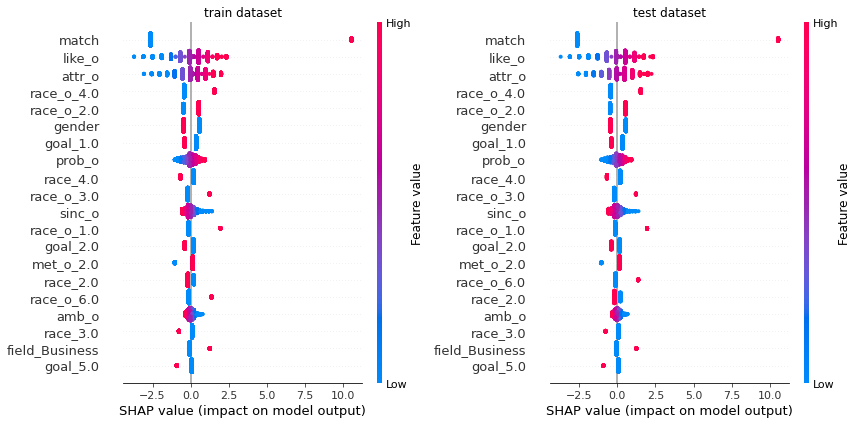

Wall time: 2.13 s


In [172]:
%%time 
# logistic regreassion via sklearn 1 (lgsk0)
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
logreg_explainer0 = shap.Explainer(logreg_best0, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values0_train = logreg_explainer0.shap_values(X_train_mean_scaled_odmb)
#shap.summary_plot(logreg_shap_values0_train, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values0_test = logreg_explainer0.shap_values(X_test_mean_scaled_odmb)
#shap.summary_plot(logreg_shap_values0_test, X_test_mean_scaled_odmb)

# make subplot
# https://stackoverflow.com/questions/64521011/plotting-shap-plots-in-2x2-grid
# https://github.com/slundberg/shap/issues/780
# https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.summary_plot.html
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.subplot(1,2,1)
shap.summary_plot(logreg_shap_values0_train, X_train_mean_scaled_odmb, plot_size=None, show=False)
plt.title('train dataset')
plt.subplot(1,2,2)
shap.summary_plot(logreg_shap_values0_test, X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('test dataset')
plt.tight_layout()
plt.show()

Make sure the train and test dataset gives comparable trend: lgsk0 model gave all the same top 20 important features in order for both train and test datasets (except for swapping the order of reace_2.0 and race_o_6.0)

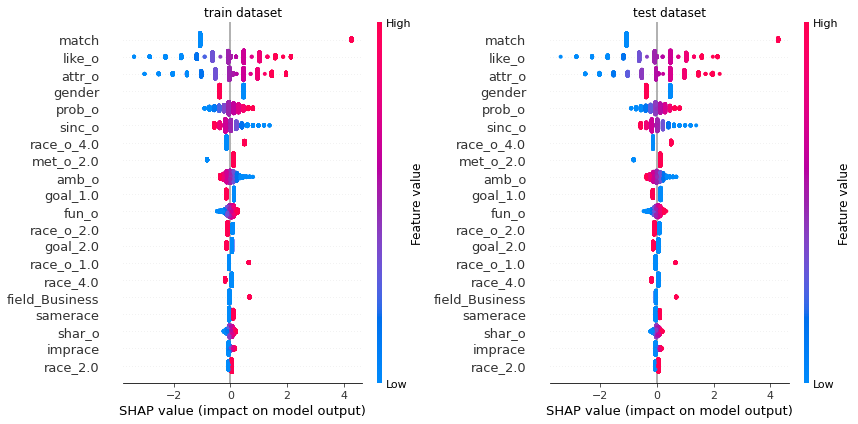

Wall time: 2.06 s


In [171]:
%%time 
# logistic regreassion via sklearn 2 (lgsk1)
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values1_train = logreg_explainer1.shap_values(X_train_mean_scaled_odmb)
#shap.summary_plot(logreg_shap_values1_train, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values1_test = logreg_explainer1.shap_values(X_test_mean_scaled_odmb)
#shap.summary_plot(logreg_shap_values1_test, X_test_mean_scaled_odmb)

# make subplot
# https://stackoverflow.com/questions/64521011/plotting-shap-plots-in-2x2-grid
# https://github.com/slundberg/shap/issues/780
# https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.summary_plot.html
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.subplot(1,2,1)
shap.summary_plot(logreg_shap_values1_train, X_train_mean_scaled_odmb, plot_size=None, show=False)
plt.title('train dataset')
plt.subplot(1,2,2)
shap.summary_plot(logreg_shap_values1_test, X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('test dataset')
plt.tight_layout()
plt.show()

Make sure the train and test dataset gives comparable trend: lgsk1 model gave all the same top 20 important features in order for both train and test datasets.

### 3.7.2 Random Forest via sklearn using shap

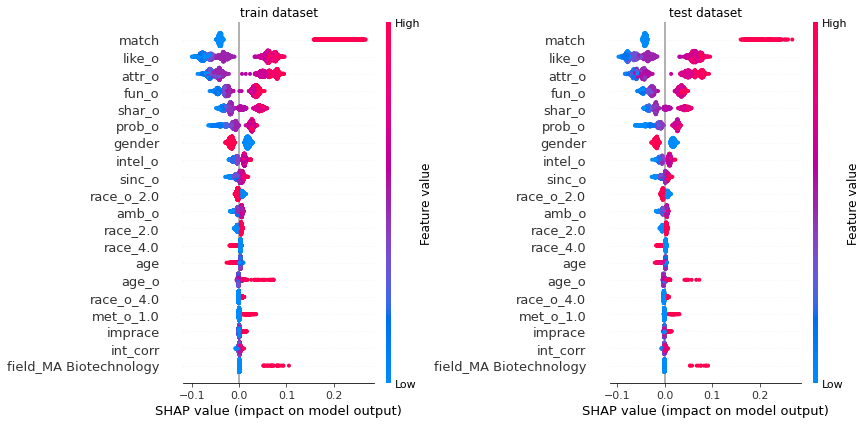

Wall time: 56.3 s


In [174]:
%%time 
# Random forest model 1 (rfc0)
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.ipynb'
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
rfc_explainer0 = shap.TreeExplainer(rfc_best0, feature_names=X_train_mean_scaled_odmb.columns)
rfc_shap_values0_train = rfc_explainer0.shap_values(X_train_mean_scaled_odmb, approximate=False, check_additivity=False)
#shap.summary_plot(rfc_shap_values0_train[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
rfc_shap_values0_test = rfc_explainer0.shap_values(X_test_mean_scaled_odmb, approximate=False, check_additivity=False)
#shap.summary_plot(rfc_shap_values0_test[1], X_test_mean_scaled_odmb)

# make subplot
# https://stackoverflow.com/questions/64521011/plotting-shap-plots-in-2x2-grid
# https://github.com/slundberg/shap/issues/780
# https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.summary_plot.html
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.subplot(1,2,1)
shap.summary_plot(rfc_shap_values0_train[1], X_train_mean_scaled_odmb, plot_size=None, show=False)
plt.title('train dataset')
plt.subplot(1,2,2)
shap.summary_plot(rfc_shap_values0_test[1], X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('test dataset')
plt.tight_layout()
plt.show()

Make sure the train and test dataset gives comparable trend: rfc0 model gave all the same top 20 important features in order for both train and test datasets.

### 3.7.3 Feature importance comparison among Models (lgsk0, lgsk1, rfc0) using shap

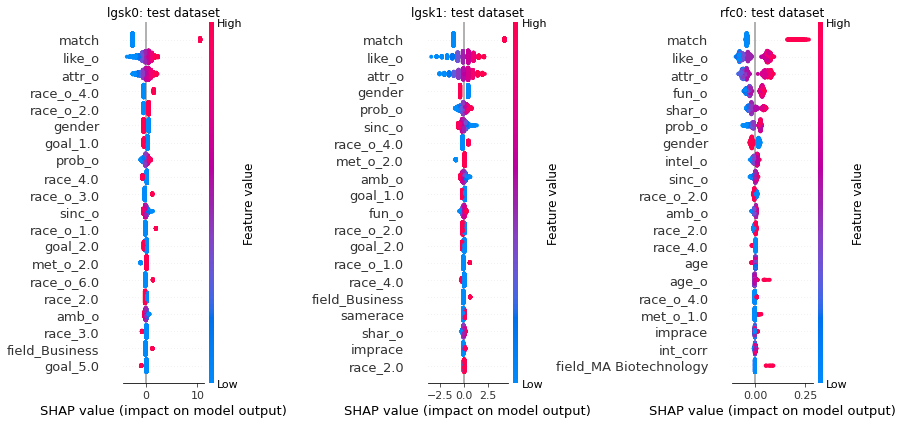

In [179]:
# make subplot on test dataset (already checked train and test dataset gave comparable trend per model)
# https://stackoverflow.com/questions/64521011/plotting-shap-plots-in-2x2-grid
# https://github.com/slundberg/shap/issues/780
# https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.summary_plot.html
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
plt.subplot(1,3,1)
shap.summary_plot(logreg_shap_values0_test, X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('lgsk0: test dataset')
plt.subplot(1,3,2)
shap.summary_plot(logreg_shap_values1_test, X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('lgsk1: test dataset')
plt.subplot(1,3,3)
shap.summary_plot(rfc_shap_values0_test[1], X_test_mean_scaled_odmb, plot_size=None, show=False)
plt.title('rfc0: test dataset')
plt.tight_layout()
plt.show()

**shap plot interpretation**
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

Refererence: 'https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a'

#### sklearn logistic regression models (lgsk0, lgsk1) and a random forest model (rfc0): both genders, test dataset

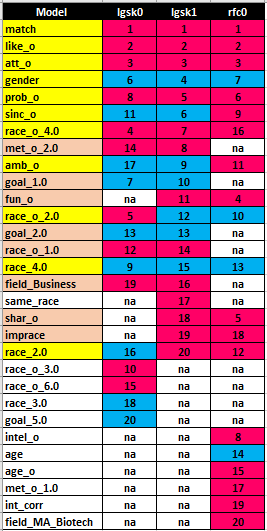

- Since top 20 important features are the same between train set and test set, test dataset analysis was used for this comparison.
- Top 20 important features for each model are ranked 1-20 and ordered using lgsk1 order, with positive correlation highlited in pink and negative correlation highlighted in light blue.
- The features ranked within top 20 for all three models are highted in yellow, and for two models are highted in salmon pink.
    - Positive correlation (3 models): match, like_o, attr_o, prob_o, race_o_4.0.
        - match: this feature has overlapping meaning with our target feature (dec_o) so having high correlation is no surprising. Positive matching means that both subject and the partner rated the subject want to date each other while positive dec_o means that the partner wants to date the subject.
        - like_o, attr_o, fun_o: the higher the partner rate the subject in how much they like the subject, and his/her attractiveness, the more likely the pertner will want to date the subject. 
        - prob_o: The more the parner think the subject want to date them (prob_o), the pertner will want to date the subject.
        - race_o_4.0: Asian/Pacific Islander/Asian-American partners tend give more yes decision to date the subject.
    - Positive correlation (2 models): met_o_2.0, fun_o, race_o_1.0, race_o_6.0, fild_Business, shar_o, imprace.    
        - met_o_2.0: the partner tends to want to date the subject whom they have never met.
        - fun_o: the higher the partner rate the subject in their funniness, the more likely the pertner will want to date the subject. 
        - race_o_1.0: African American partners tend give more yes decision to date the subject.
        - race_o_6.0: Partners who are not "African American, European/Caucasian-American, Latino/Hispanic American, Asian/Pacific Islander/Asian-American, Native American" tend give more yes decision to date the subject.
        - fild_Business: Subjects majoring Business are popular and likely to get more yes decision to date from a partner.
        - shar_o: The more the parner think they share the interests/hobbies with the subject, the more likely the pertner will want to date the subject.
        - imprace: the subject who cares more about dating a partner with the same race tend to get more yes decision to date from a partner.    
    - Negative correlation (3 models): gender, race_4.0.
        - gender: subject gender (0=female, 1=male) is opposite of the partner gender, meaning female partner tend to give more no decision to date the subject while male parner tend to give more yes decision to date the subject.
        - race_4.0: Asian/Pacific Islander/Asian-American subjects are not popular and likely to get more no decision to date from a partner.
    - Negative correlation (2 models): goal_1.0, goal_2.0.
        - goal_1.0, goal_2.0: Subjects with less serious goal such as "to have a fun night out (goal_1.0)" or "to meet new people (goal_2.0)" tend to get more no decision to date from a partner. More serious goal examples are "to get a date" and "to look for a serious relationship".
    - Pos/Neg correlation (3 models): sinc_o, amb_o, race_o_2.0, race_2.0
        - sinc_o, amb_o: the higher the partner rate the subject's sincerity and ambition, the less likely the pertner will want to date the subject according to two but one models.
        - race_o_2.0: European/Caucasian-American partners tend give more no decision to date the subject, according to two but one models.
        - race_2.0:European/Caucasian-American partners subjects are popular and likely to get more yes decision to date from a partner, according to two but one models.      

## 3.8 Conclusion
Most powerful model in terms of model evaluation metrics, computational complexity, scalability, and maintenance costs: 
- If by far the longest training time (\~47.5 min) is not a issue, **finer tuned sklearn's logististic regression model (lgsk1)** resulted in higest f1-score (\~80.1%) and recall (\~81.9%), 2nd to lowest model size (23k bytes), the 3rd best precision (\~78.5%) and 3rd shortest prediction time (in microseconds).
- If almost an hour long training time is a issue, **simpler sklearn's logistic regression model (lgsk0)** resulted in 2nd highest f1-score (\~79.0%), recall (\~78.7%) and precision (\~79.3%), lowest model size (\~4.8k bytes), shortest training time (\~1.5 min), and 2nd shortest prediction time (few microseconds). 
    - from nature of model, logistic regression model will be more scalable than random forest model (more complicated the tree models, takes up more storage space than logistic regression model). 
    
From the feature importance anaysis we made following observations:
- As predicted, the more attractive, fun and likable people with more common interests/hobbies are popular tend to get a date.
- Something interesting is that people want to date someone who are more likely to be attracted to them. Sure, no one likes to be rejected.
- People want to date the someone whom they have never met.
- Asian/Pacific Islander/Asian-American and African American people seem to be less picky on who they want to date compared to European/Caucasian-American and Latino/Hispanic American people.
- Asian/Pacific Islander/Asian-American seem to be less popular among the 4 races mentioned above.
- People prefer to date someone with the same race.
- People with more serious goal in mind on attending the speed dating events are more popular
- People majoring Business are popular.
- Female are more picky on who they want to date than male.
- Some features have mixed evaluation depending on models.

At least, we were able to answer 3 out of 7 questions we have set at the beginning of this study below. 

Questions to be answers:
1. What are the desirable attributes?
2. What are the desirable races?
3. What are the desirable majors?
4. The difference of desirable attributes in a male partner vs female partner.
5. The difference of desirable attributes among races.
6. The difference of desirable major of male partner vs female partner
7. The difference of desirable majors among races.  

## 3.9 Next Step
Possible ways to imporve the models:
- Reduce the cardinality to reduce the number of category with missing dataset (reduce the sparsity of the dataset).
- Might use bag & boost to do feature importance analysis to pre-select the more relevant dataset as feature for better explanation & understanding.
- Multiple candidates matrics prior to fitting models 
    - besides precision, recall and f1, consider sensitivity and specificity
    - weighting precision and recall using f_beta score, etc.

To answer questions on difference between genders and races.
- All the features importance analysis in this study are perfomed using dataset with both female and male attribute evaluators. Since there might some features that can be more beneficial for male than female, or vice-versa, I would like to perform the same analysis on gender seprated datasets to check if there is any feature importance difference between male and females.
- Would like to do the same to check the differences between races.

### reference
- sklearn codes:
    - '14.1.2_3_Supervised Learning_Tuning': logisticRegression, confusion_matrix, classification_report, 
    - '14.1.2_4_Supervised Learning with scikit-learn_Preprocessing and Pipeline': buiding pipeline, scaler, get_dummies() 
    - '6_GuidedCapstone/04_preprocessing_and_training_mk': scaler, Random Forest model
     - '14.2.11_Case Study - Logistic Regression/Logistic Regression Advanced Case Study_mk': plot logisticRegression output.
- Statsmodel codes:
    - '11.4.1_Case Study - Linear Regression/Regression Case Study - the Red Wine Dataset - Tier 3_mk': sm.OLS(y, X), plot predictions (y_test vs. y_pred)
- Random Forest model codes:'14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.3.5_Case Study - Decision Trees - RR Diner Coffee/Decision Tree Specialty Coffee Case Study - Tier 3_mk'
    
- refer to 'https://pandas.pydata.org/pandas-docs/version/0.24.0rc1/api/generated/pandas.Series.to_numpy.html'
    - series to numpy: s.to_numpy()
- data preprocessing: 
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk': get_dummies(), sklearn scaler
    - '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk': exctract categorical data
    - '15.4.3_3_Unsupervised Learning_Dimension reduction': PCA
- feature importance interpretation: SHAP
    - https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://ff06-2020.fastforwardlabs.com/
   

### Questions:
- how do perform cross validation on statsmodel?
    - Answers:
    - currently not avaliable(can't perform cross validation using statsmodels.api yet) and is not compatibible with sklearn cross_val_score or GredSearchCV...etc
    - need to write custom codes if you really want to
    - people usually use sklearn for building ML model.
    - statsmodel is used for quick stats calculation from a model than model optimazation. 
- how to use ElasticNet in sklearn LogisticRegression? (currently only l1 or l2 are available!?)
    - Answers:
    - need to change the default solver (lbfgs) to saga in order to use elasticnet
        - param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 
        - logreg = LogisticRegression(solver='saga', max_iter=10000) 
        - logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
- how to compare the performance of statsmodel and sklearn lotistic model
    - Answers:
    - use sklearn confusion_matrix, classification_report on the y_pred, y_test
    - need to convert the statsmodel's y_pred in probability to binary system (0,1) in advance
    
- how to choose scoring system for GridSearhCV like we can do for cross_val_score? (what is the defaut score?, accuracy?)
    - cv_accuracy = cross_val_score(clf, Xlr, ylr, cv=5, scoring='accuracy')
    - cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    - Answers:
    - use GridSearhCV(logreg, param_grid, scoring = 'roc_auc', cv=5), default scoring = 'accuracy'
    - should not use 'accuracy' scoring for data with imbalanced disribution.
    - for logistic regression, target variable (0,1), 
        - one opinion: if there is much more (more than 10x!?) 1 than 0 (or vice verso) > imbalanced data
        - another opinion: accuracy for 50:50 balance data is fine, if there is 60:40 > imbalanced data, and start to doubt the accuracy as metric, and use log loss as metric instead.
- for logistic regression model, do I need to leave all the binary variable (or only dependent variable) out for scaling.
    - Answers: 
    - leaving it out all the binary viarable for scaling for logistic regression model might be better!?
- how to measure size of model? 
    - import sys 
    - ie) sys.getsizeof(logreg_best0)
- How to save %%time, model running time? Just input manually 
    - it's ok to take a long time to training the data set. 
    - need to separate how the prediction code and compare the time take for prediciton for each model.
    - start_time = datetime.datetime.now(): need to put this right before
    - run_time = datetime.datetime.now() - start_time: need to put this right after the code want to meature the time
- which matrix to compare within classification report?
    - If cost to give wrong recommendation is high, then precison is important in the recommendation prediction system than recall (recall is often more important for marketing prediction system).
    - if rhere is no precison/recall preference, ROC is often compared.